In [200]:
%matplotlib inline

import os
import glob
import json
import time
import copy
import pickle
import datetime

import bcolz
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from IPython.display import display

import utils
import config

In [2]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [3]:
def csv_predictions_to_array(path):
    frame = pd.read_csv(path)
    d = {}
    for index, row in frame.iterrows():
        d[row['image']] = np.array(row[:-1], dtype=np.float32)
    return np.array([d[k] for k in sorted(d)])


def create_rect_xywh(box, color='red'):
    return plt.Rectangle((box[0], box[1]), box[2], box[3],
                         color=color, fill=False, linewidth=2)

def plot(img):
    x = copy.copy(img)
    x = x + max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    plt.imshow(np.array(x, dtype=np.uint8))

In [4]:
index = 0
info_string = 'fish'
prefix = os.path.join('cache', info_string + '_' + str(index))

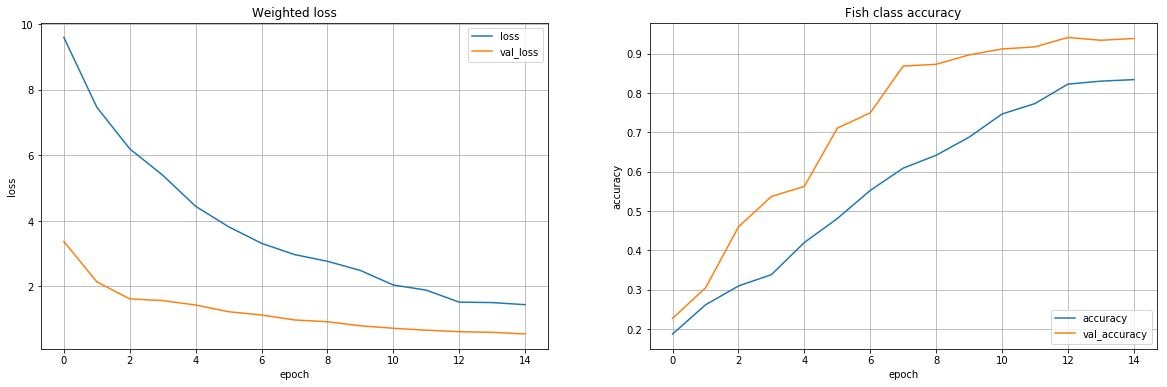

In [114]:
history = pickle.load(open(prefix + '_history.p', 'rb'))

plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.title('Weighted loss')
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(122)
plt.title('Fish class accuracy')
plt.plot(history['acc'], label='accuracy')
plt.plot(history['val_acc'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.show()

In [115]:
real = csv_predictions_to_array('test_stg1.csv')
pred = csv_predictions_to_array('cache/fish_0_2017-02-06-15-30.csv')

def do_clip(arr, mx):
    clipped = np.clip(arr, (1-mx)/1, mx)
    return clipped/clipped.sum(axis=1)[:, np.newaxis]

diff = 0
for i in range(len(real)):
    if np.argmax(real[i]) != np.argmax(pred[i]):
        diff += 1

print('Diff:', diff)
print('Log loss:', log_loss(real, pred))
print('Clipped log loss:', log_loss(real, do_clip(pred, 0.96)))

Diff: 306
Log loss: 1.09050957745
Clipped log loss: 1.05825683182


In [109]:
X_test = utils.load_array('X_test.bcolz')
Id_test = utils.load_array('Id_test.bcolz')
y_test_bb_tl = utils.load_array('y_test_bb_tl.bcolz')
y_test_bb_wh = utils.load_array('y_test_bb_wh.bcolz')

print('X_test:', np.shape(X_test))
print('Id_test:', np.shape(Id_test))
print('y_test_bb_tl:', np.shape(y_test_bb_tl))
print('y_test_bb_wh:', np.shape(y_test_bb_wh))

Id_test_argsort = np.argsort(Id_test)

def show_pred(i, bb=False):
    plt.figure(figsize=(9, 12))
    plot(X_test[Id_test_argsort[i]])
    ax = plt.gca()
    print('Id: ', Id_test[Id_test_argsort[i]])
    p = pred[i]
    print('Pred: {} ({:.3f})'.format(classes[np.argmax(p)], p[np.argmax(p)]))
    print('Real:', classes[np.argmax(real[i])])
    if bb:
        box = []
        box.extend(y_test_bb_tl[Id_test_argsort[i]])
        box.extend(y_test_bb_wh[Id_test_argsort[i]])
        print('Box (x,y,w,h): ', box)
        if box[2] > 0 and box[3] > 0:
            ax.add_patch(create_rect_xywh(box, 'yellow'))

X_test: (1000, 448, 448, 3)
Id_test: (1000,)
y_test_bb_tl: (2,)
y_test_bb_wh: (2,)


Id:  img_03715.jpg
Pred: ALB (0.701)
Real: LAG


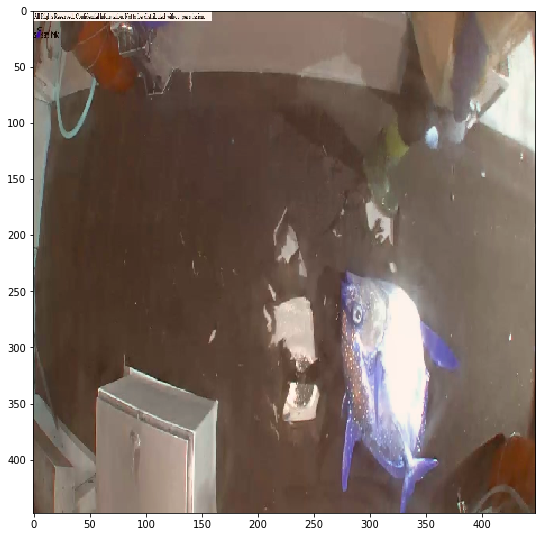

In [116]:
show_pred(451)

In [117]:
pred_p = {}
real_p = {}
for i in range(len(classes)):
    pred_p[classes[i]] = 0
    real_p[classes[i]] = 0

total = 0
for i in range(len(pred)):
    for j in range(len(classes)):
        pred_p[classes[j]] += pred[i][j]
        real_p[classes[j]] += real[i][j]

for i in range(len(classes)):
    pp = pred_p[classes[i]] / len(pred) * 100.0
    rp = real_p[classes[i]] / len(pred) * 100.0
    print('{}\tpred: {:.2f}%\treal: {:.2f}%\tbias: {:.3f}'.format(classes[i], pp, rp, pp/rp))

ALB	pred: 53.09%	real: 51.50%	bias: 1.031
BET	pred: 5.22%	real: 6.20%	bias: 0.842
DOL	pred: 0.82%	real: 1.60%	bias: 0.510
LAG	pred: 1.29%	real: 3.70%	bias: 0.349
NoF	pred: 14.29%	real: 12.20%	bias: 1.171
OTHER	pred: 4.75%	real: 8.20%	bias: 0.579
SHARK	pred: 1.90%	real: 3.00%	bias: 0.633
YFT	pred: 18.65%	real: 13.60%	bias: 1.372


In [202]:
c_matrix = {}
p_matrix = {
    'TP': {},
    'FP': {},
    'FN': {},
    'TN': {},
    'ACC': {},
    'REC': {},
    'PRE': {},
    'F1': {}
}

for i in range(len(classes)):
    tl = classes[i] + '_T'
    c_matrix[tl] = {}
    for j in range(len(classes)):
        pl = classes[j] + '_P'
        c_matrix[tl][pl] = 0

for i in range(len(classes)):
    cn = classes[i]
    p_matrix['TP'][cn] = 0
    p_matrix['FP'][cn] = 0
    p_matrix['FN'][cn] = 0
    p_matrix['TN'][cn] = 0
    p_matrix['ACC'][cn] = 0
    p_matrix['REC'][cn] = 0
    p_matrix['PRE'][cn] = 0
    p_matrix['F1'][cn] = 0
        
for i in range(len(pred)):
    predicted = classes[np.argmax(pred[i])]
    truelabel = classes[np.argmax(real[i])]
    c_matrix[truelabel + '_T'][predicted + '_P'] += 1
    
    if predicted == truelabel:
        p_matrix['TP'][predicted] += 1
    else:
        p_matrix['FP'][predicted] += 1
        p_matrix['FN'][truelabel] += 1

for i in range(len(classes)):
    cn = classes[i]
    tp = int(p_matrix['TP'][cn])
    fn = int(p_matrix['FN'][cn])
    fp = int(p_matrix['FP'][cn])
    tn = p_matrix['TN'][cn] = len(pred) - (tp + fn + fp)
    p_matrix['ACC'][cn] = (tp + tn) / (tp + tn + fp + fn)
    r = p_matrix['REC'][cn] = tp / (tp + fn)
    p = p_matrix['PRE'][cn] = tp / (tp + fp)
    p_matrix['F1'][cn] = 2 * (p * r) / (p + r)

#pd.options.display.float_format = '{:,.2f}'.format
display(pd.DataFrame(c_matrix))
display(pd.DataFrame(p_matrix)[['TP', 'FP', 'TN', 'FN', 'PRE', 'REC', 'F1', 'ACC']])

,ALB_T,BET_T,DOL_T,LAG_T,NoF_T,OTHER_T,SHARK_T,YFT_T
ALB_P,480,47,2,27,11,64,16,53
BET_P,13,7,0,0,3,1,6,4
DOL_P,0,0,1,0,0,0,0,1
LAG_P,2,0,0,6,0,0,0,0
NoF_P,11,0,0,0,108,0,0,0
OTHER_P,1,0,0,0,0,6,0,0
SHARK_P,0,0,0,0,0,0,8,0
YFT_P,8,8,13,4,0,11,0,78


,TP,FP,TN,FN,PRE,REC,F1,ACC
ALB,480,220,265,35,0.69,0.93,0.79,0.74
BET,7,27,911,55,0.21,0.11,0.15,0.92
DOL,1,1,983,15,0.50,0.06,0.11,0.98
LAG,6,2,961,31,0.75,0.16,0.27,0.97
NoF,108,11,867,14,0.91,0.89,0.90,0.97
OTHER,6,1,917,76,0.86,0.07,0.13,0.92
SHARK,8,0,970,22,1.00,0.27,0.42,0.98
YFT,78,44,820,58,0.64,0.57,0.60,0.90
